This kernel presents how to build an ASE database from CHAMPS data and create a dataset, and then uses it for molecular property predictions.

First, please see an SchNet tutorial on QM9:

[SchNet QM9](https://www.kaggle.com/tonyyy/schnet-qm9)

which contains references of the SchNet architecture.

This kernel uses only potential energies and dipole moments in CHAMPS data. Mulliken charges and magnetic shielding tensors are used in the following kernels:
* [SchNet Mulliken Charges](https://www.kaggle.com/tonyyy/schnet-mulliken-charges)
* [SchNet Magnetic Shielding](https://www.kaggle.com/tonyyy/schnet-magnetic-shielding)

In [1]:
!pip install schnetpack

     |████████████████████████████████| 61kB 5.1MB/s 
     |████████████████████████████████| 1.8MB 15.6MB/s 
  Stored in directory: /tmp/.cache/pip/wheels/4e/28/d3/1748daf79d0a526f1a2de70e9a3abcdb50eb01b45eeec4b786
Successfully built schnetpack


In [2]:
!ls ../input

dipole_moments.csv		sample_submission.csv		   test.csv
magnetic_shielding_tensors.csv	scalar_coupling_contributions.csv  train.csv
mulliken_charges.csv		structures
potential_energy.csv		structures.csv


# CHAMPS data

In [3]:
import numpy as np
import pandas as pd
molecules = pd.read_csv('../input/structures.csv')
molecules = molecules.groupby('molecule_name')
energies = pd.read_csv('../input/potential_energy.csv')
dipoles = pd.read_csv('../input/dipole_moments.csv')
dipoles['scalar'] = np.sqrt(np.square(dipoles[['X', 'Y', 'Z']]).sum(axis=1))

The total number of molecules:

In [4]:
molecules.ngroups

130775

### Potential Energy

In [5]:
energies.head()

,molecule_name,potential_energy
0,dsgdb9nsd_000001,-40.52368
1,dsgdb9nsd_000002,-56.56025
2,dsgdb9nsd_000003,-76.42608
3,dsgdb9nsd_000005,-93.42849
4,dsgdb9nsd_000007,-79.83869


In [6]:
len(energies)

85003

In [7]:
energy_series = pd.Series(energies.set_index('molecule_name')['potential_energy'])
energy_series.describe()

count    85003.000000
mean      -410.874055
std         39.828871
min       -714.626200
25%       -438.000750
50%       -416.921700
75%       -387.218950
max        -40.523680
Name: potential_energy, dtype: float64

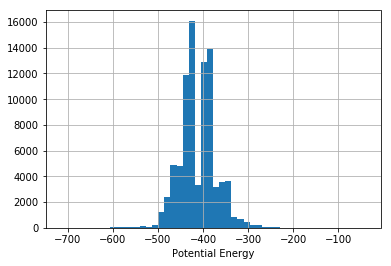

In [8]:
ax = energy_series.hist(bins=50)
_ = ax.set_xlabel("Potential Energy")

### Dipole Moment

In [9]:
dipoles.head()

,molecule_name,X,Y,Z,scalar
0,dsgdb9nsd_000001,0.0000,0.0,0.0000,0.0000
1,dsgdb9nsd_000002,-0.0002,0.0,1.6256,1.6256
2,dsgdb9nsd_000003,0.0000,0.0,-1.8511,1.8511
3,dsgdb9nsd_000005,0.0000,0.0,-2.8937,2.8937
4,dsgdb9nsd_000007,0.0000,0.0,0.0000,0.0000


In [10]:
len(dipoles)

85003

In [11]:
dipole_series = pd.Series(dipoles.set_index('molecule_name')['scalar'])
dipole_series.describe()

count    85003.000000
mean         2.672361
std          1.492801
min          0.000000
25%          1.581295
50%          2.474998
75%          3.600646
max         22.960504
Name: scalar, dtype: float64

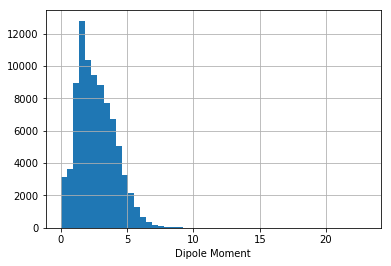

In [12]:
ax = dipole_series.hist(bins=50)
_ = ax.set_xlabel("Dipole Moment")

# ASE Database

A dataset object used in SchNetPack is built on an ASE database. Please see the document of the ASE database:

https://wiki.fysik.dtu.dk/ase/ase/db/db.html

In [13]:
train = pd.read_csv('../input/train.csv')
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


In [14]:
train_molecule_names = train.molecule_name.unique()
len(train_molecule_names)

85003

In [15]:
from ase import Atoms
from ase.db import connect

def create_db(db_path, molecule_names):
    with connect(db_path) as db:
        for name in molecule_names:
            mol = molecules.get_group(name)
            atoms = Atoms(symbols=mol.atom.values,
                          positions=[(row.x,row.y,row.z) for row in mol.itertuples()])
            db.write(atoms, name=name,
                     potential_energy=energy_series.get(name, default=float('nan')),
                     scalar_dipole=dipole_series.get(name, default=float('nan'))
                    )

In [16]:
champs_path = 'CHAMPS_train.db'
dataset_size = len(train_molecule_names) # 20000
dataset_molecule_names = train_molecule_names[:dataset_size]
create_db(db_path=champs_path, molecule_names=dataset_molecule_names)

In [17]:
with connect(champs_path) as db:
    print(len(db))

85003


In [18]:
import schnetpack

properties=['potential_energy', 'scalar_dipole']

dataset = dict()
for p in properties:
    dataset[p] = schnetpack.data.AtomsData(champs_path, properties=[p])

In [19]:
for p in properties:
    print(p, len(dataset[p]))

potential_energy 85003
scalar_dipole 85003


# SchNet Model

Please see the SchNetPack API document:

https://schnetpack.readthedocs.io/en/stable/modules/index.html

In [20]:
import pandas as pd

import torch
import torch.nn.functional as F
from torch.optim import Adam

import schnetpack as spk
import schnetpack.atomistic as atm
import schnetpack.representation as rep
from schnetpack.datasets import *

device = torch.device("cuda")

In [21]:
# This function comes from the following script:
# https://github.com/atomistic-machine-learning/schnetpack/blob/v0.2.1/src/scripts/schnetpack_qm9.py
def evaluate_dataset(metrics, model, loader, device):
    for metric in metrics:
        metric.reset()

    with torch.no_grad():
        for batch in loader:
            batch = {
                k: v.to(device)
                for k, v in batch.items()
            }
            result = model(batch)

            for metric in metrics:
                metric.add_batch(batch, result)

    results = [
        metric.aggregate() for metric in metrics
    ]
    return results

In [22]:
def schnet_model(property):
    reps = rep.SchNet(n_interactions=6)
    if 'dipole' in property:
        print('use dipole moment')
        output = atm.DipoleMoment(n_in=128, predict_magnitude=True)
    else:
        output = atm.Atomwise()
    model = atm.AtomisticModel(reps, output)
    model = model.to(device)
    
    return model

In [23]:
def train_model(property, max_epochs=500):
    # split in train and val
    n_dataset = len(dataset[property])
    n_val = n_dataset // 10
    train_data, val_data, test_data = dataset[property].create_splits(n_dataset-n_val*2, n_val)
    train_loader = spk.data.AtomsLoader(train_data, batch_size=128, num_workers=2)
    val_loader = spk.data.AtomsLoader(val_data, batch_size=256, num_workers=2)

    # create model
    model = schnet_model(property)

    # create trainer
    opt = Adam(model.parameters(), lr=2e-4, weight_decay=1e-6)
    loss = lambda b, p: F.mse_loss(p["y"], b[property])
    metrics = [
        spk.metrics.MeanAbsoluteError(property, "y"),
        spk.metrics.RootMeanSquaredError(property, "y"),
    ]
    hooks = [
        spk.train.MaxEpochHook(max_epochs),
        spk.train.CSVHook(property+'/log', metrics, every_n_epochs=1),
    ]
    trainer = spk.train.Trainer(property+'/output', model, loss,
                            opt, train_loader, val_loader, hooks=hooks)

    # start training
    trainer.train(device)
    
    # evaluation
    model.load_state_dict(torch.load(property+'/output/best_model'))
    test_loader = spk.data.AtomsLoader(test_data, batch_size=256, num_workers=2)
    model.eval()

    df = pd.DataFrame()
    df['metric'] = ['MAE', 'RMSE']
    df['training'] = evaluate_dataset(metrics, model, train_loader, device)
    df['validation'] = evaluate_dataset(metrics, model, val_loader, device)
    df['test'] = evaluate_dataset(metrics, model, test_loader, device)
    display(df)
    
    return test_data

In [24]:
def show_history(property):
    df = pd.read_csv(property+'/log/log.csv')
    display(df.tail())
    max_value = None # df['RMSE_'+property].min()*5
    _ = df[['MAE_'+property,'RMSE_'+property]].plot(ylim=(0,max_value))

In [25]:
def test_prediction(dataset, property):
    # create model
    model = schnet_model(property)
    
    # load the best parameters
    model.load_state_dict(torch.load(property+'/output/best_model'))
    loader = spk.data.AtomsLoader(dataset, batch_size=256, num_workers=2)
    model.eval()
    
    # predict molecular properties
    targets = []
    predictions = []
    with torch.no_grad():
        for batch in loader:
            batch = {
                k: v.to(device)
                for k, v in batch.items()
            }
            result = model(batch)
            targets += batch[property].squeeze().tolist()
            predictions += result['y'].squeeze().tolist()
    return targets, predictions

In [26]:
def show_predictions(dataset, property):
    targets, predictions = test_prediction(dataset, property)
    df_pred = pd.DataFrame()
    df_pred['Target'] = targets
    df_pred['Prediction'] = predictions
    df_pred.plot.scatter(x='Target', y='Prediction', title=property)

# Results

potential_energy


,metric,training,validation,test
0,MAE,0.108276,0.108030,0.110248
1,RMSE,0.156052,0.154651,0.203153


,Time,Learning rate,Train loss,Validation loss,MAE_potential_energy,RMSE_potential_energy
95,10826.145489,0.0002,325.225906,0.035993,0.139643,0.189719
96,10941.673172,0.0002,86.791151,0.081091,0.251176,0.284765
97,11057.247860,0.0002,142.982768,2.050616,1.211110,1.431997
98,11173.105372,0.0002,191.592895,0.509969,0.601874,0.714121
99,11289.696398,0.0002,211.111011,0.132101,0.308596,0.363457


scalar_dipole
use dipole moment


,metric,training,validation,test
0,MAE,0.045937,0.056131,0.055776
1,RMSE,0.063371,0.091292,0.085729


,Time,Learning rate,Train loss,Validation loss,MAE_scalar_dipole,RMSE_scalar_dipole
95,10222.832104,0.0002,3.277130,0.009312,0.057885,0.096498
96,10323.589116,0.0002,2.610765,0.008959,0.060342,0.094650
97,10424.347646,0.0002,3.306240,0.008862,0.057782,0.094139
98,10525.306760,0.0002,2.562179,0.009329,0.057540,0.096588
99,10626.811887,0.0002,4.514397,0.008334,0.056131,0.091292


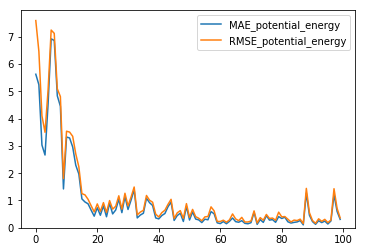

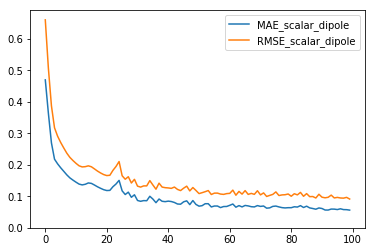

In [27]:
used_test_data = dict()
for p in properties:
    print(p)
    used_test_data[p] = train_model(p, max_epochs=100)
    show_history(p)

use dipole moment


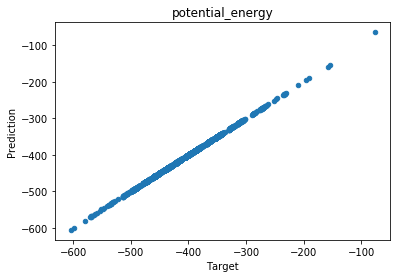

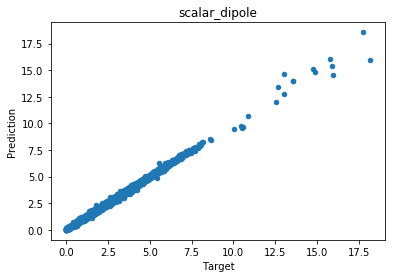

In [28]:
for p in properties:
    show_predictions(used_test_data[p], p)

In [29]:
!mv potential_energy/log/log.csv log_potential.csv
!mv scalar_dipole/log/log.csv log_dipole.csv
!mv potential_energy/output/best_model best_model_potential
!mv scalar_dipole/output/best_model best_model_dipole
!rm -r potential_energy
!rm -r scalar_dipole

In [30]:
!ls

CHAMPS_train.db     __output__.json    best_model_potential  log_potential.csv
__notebook__.ipynb  best_model_dipole  log_dipole.csv
